# Adversarial Patch Attacks

In this notebook we will experiment with **adversarial patch attacks**, against a pre-trained model from robustbench. Exploring how the patch can be easely constructed using secml-torch.

In [4]:
%%capture
try:
    import secmlt
except ImportError:
   %pip install secml-torch[foolbox,adv_lib]

try:
  import robustbench
except ImportError:
   %pip install robustbench
   %pip install git+https://github.com/fra31/auto-attack

In [5]:
%%capture
import torch
import torchvision.datasets
from robustbench.utils import load_model
from secmlt.metrics.classification import Accuracy
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from torch.utils.data import DataLoader, Subset

#### Loading Pre-trained Model and Dataset

In [11]:
%%capture
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = load_model(model_name="Rony2019Decoupling", dataset="cifar10", threat_model="L2")
net.to(device).eval()

num_samples, batch_size = 100, 5
test_ds = Subset(
    torchvision.datasets.CIFAR10(root=".", train=False, download=True, transform=torchvision.transforms.ToTensor()),
    list(range(num_samples))
)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

cifar10_labels = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

clf = BasePytorchClassifier(net)



#### Adversarial Patch Attack Construcion

In [8]:
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD
from secmlt.optimization.constraints import MaskConstraint

In [ ]:
eps, steps, step_size = 10, 100, 1e-2
pgd = PGD(
    perturbation_model=LpPerturbationModels.L2,
    epsilon=eps,
    num_steps=steps,
    step_size=step_size,
    random_start=True,
    backend=Backends.NATIVE,
    lb=0.0, ub=1.0
)

# --- Patch construction ---
x_batch, _ = next(iter(test_loader))
B, C, H, W = x_batch.shape
k, top, left = 8, 8, 8  # patch 8x8
mask = torch.zeros(B, C, H, W, device=x_batch.device)
mask[:, :, top:top+k, left:left+k] = 1.0

pgd.manipulation_function.perturbation_constraints.append(MaskConstraint(mask))

acc_clean = Accuracy()(clf, test_loader)
adv_loader = pgd(clf, test_loader)
acc_adv   = Accuracy()(clf, adv_loader)

print(f"Clean Accurcy.        : {acc_clean:.3f}")
print(f"Robust Accurcy.       : {acc_adv:.3f}")
print(f"Drop accuracy         : {acc_clean - acc_adv:.3f}")

Clean Accurcy.        : 0.910
Robust Accurcy.       : 0.880
Drop accuracy         : 0.030


#### Adversarial Patch Viasualization

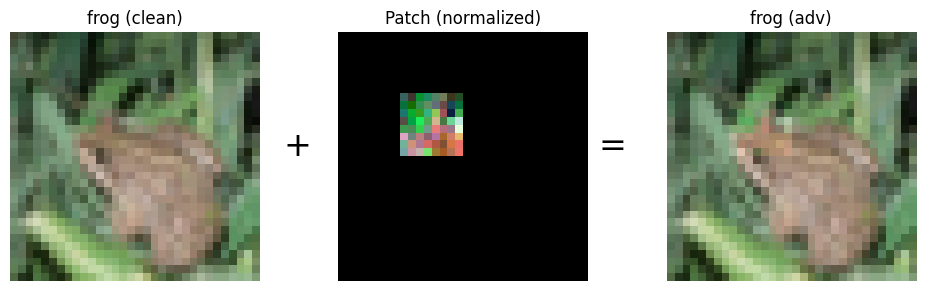

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- grab the same sample from clean and adversarial loaders ---
x_clean_b, y_clean_b = next(iter(test_loader))
x_adv_b,   y_adv_b   = next(iter(adv_loader))

idx = 4  # show the 4th sample in the batch
x_clean = x_clean_b[idx].detach().cpu()  # [C,H,W]
x_adv   = x_adv_b[idx].detach().cpu()    # [C,H,W]

# --- predicted labels for titles ---
device = next(net.parameters()).device
with torch.no_grad():
    pred_clean = int(net(x_clean.unsqueeze(0).to(device)).argmax(dim=1).item())
    pred_adv   = int(net(x_adv.unsqueeze(0).to(device)).argmax(dim=1).item())
label_clean = f"{cifar10_labels[pred_clean]} (clean)"
label_adv   = f"{cifar10_labels[pred_adv]} (adv)"

# --- patch coordinates  ---
# k, top, left = 8, 8, 8  # e.g., 8x8 patch at (top=8, left=8)

# --- build the patch-only perturbation visualization on a WHITE background ---
C, H, W = x_clean.shape
delta = (x_adv - x_clean)  # [C,H,W]

# normalize ONLY inside the patch
patch = delta[:, top:top+k, left:left+k]  # [C,k,k]
dmin, dmax = float(patch.min()), float(patch.max())
patch_norm = (patch - dmin) / (dmax - dmin + 1e-8)      # [C,k,k] in [0,1]

# white background + paste normalized patch
patch_viz = np.zeros((H, W, 3), dtype=np.float32)        # white
patch_viz[top:top+k, left:left+k, :] = patch_norm.permute(1, 2, 0).numpy()

# convert clean/adv to HxWxC np arrays for imshow
clean_img = x_clean.permute(1,2,0).clamp(0,1).numpy()
adv_img   = x_adv.permute(1,2,0).clamp(0,1).numpy()

# --- plot: clean | patch | = | adv ---
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].imshow(clean_img); axes[0].set_title(label_clean); axes[0].axis("off")
axes[1].imshow(patch_viz); axes[1].set_title("Patch (normalized)"); axes[1].axis("off")
axes[2].imshow(adv_img);   axes[2].set_title(label_adv); axes[2].axis("off")


fig.text(0.335, 0.5,  "+", fontsize=24, ha="center", va="center")
fig.text(0.65, 0.5, "=", fontsize=24, ha="center", va="center")

plt.tight_layout()
plt.show()


